<a href="https://colab.research.google.com/github/saif-raja/Capstone-Project-2_Classification-Insurance_Cross_Selling/blob/main/ML_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries
## installing dependencies

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 4.2 MB/s ta 0:00:011


In [ ]:
import os
import pickle
import pandas as pd
import numpy as np

In [ ]:
import xgboost
print('xgboost %s' % xgboost.__version__)
from xgboost import XGBClassifier

import skopt
print('skopt %s' % skopt.__version__)
from skopt import BayesSearchCV

import sklearn
print('sklearn %s' % sklearn.__version__)


xgboost 1.3.0
skopt 0.8.1
sklearn 0.23.2


In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ShuffleSplit , StratifiedKFold , RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score , cross_validate ,cross_val_predict

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix as confmat
from sklearn.metrics import precision_recall_curve , classification_report

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline


In [ ]:
import seaborn as sns
import seaborn as sb
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import colors
from matplotlib.ticker import PercentFormatter


np.seterr(all='warn', divide='warn', over='warn', under='warn', invalid='warn')

pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

import warnings
warnings.filterwarnings('ignore')

# Import cleaned final data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
filepath = '/content/drive/MyDrive/AlmaBetter/Capstone2_Supervised_Classification/Code/Data/processed_data.csv'
filepath = 'processed_data.csv'
dataset = pd.read_csv(filepath)


In [ ]:
dataset.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Sales_Channel_Target_encoded,Region_Code_Target_encoded
0,1,1,44,1,28,0,2.5,1,40454,26,217,1,0.199385,0.187163
1,2,1,76,1,3,0,1.5,0,33536,26,183,0,0.199385,0.127662
2,3,1,47,1,28,0,2.5,1,38294,26,27,1,0.199385,0.187163
3,4,1,21,1,11,1,0.5,0,28619,152,203,0,0.028624,0.112760
4,5,0,29,1,41,1,0.5,0,27496,152,39,0,0.028624,0.121776


In [ ]:
#list(dataset.columns.values)

In [ ]:
X_list = ['Gender',
 'Age',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Vintage',
 'Policy_Sales_Channel_Target_encoded',
 'Region_Code_Target_encoded']

Y_list = 'Response'

In [ ]:
X = dataset[X_list]
Y = dataset[Y_list]


In [ ]:
# 0.1 to 0.3 size of train set

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1 , shuffle =True )

In [ ]:
X_train.columns.values == X_test.columns.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
print('X_train size : ' , X_train.shape )
print('Y_train size : ' , Y_train.shape )
print('X_test  size : ' , X_test.shape )
print('Y_test  size : ' , Y_test.shape )

X_train size :  (342998, 10)
Y_train size :  (342998,)
X_test  size :  (38111, 10)
Y_test  size :  (38111,)


---------
----

# Defining Scoring Metrics Custom definations


https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

https://scikit-learn.org/stable/modules/model_evaluation.html#using-multiple-metric-evaluation


### Random Forrest Specific Cutom Defined Metrics


In [ ]:
def RF_Forrest_Depth (clf , X , y): 
    #return value and std.dev. of forest tree depth
    
    depth_list = np.array([])
    #leaves_list = np.array([])
    for i in range(len(clf.estimators_)):
        depth_list  = np.append( depth_list , clf.estimators_[i].get_depth())
        #leaves_list = np.append(leaves_list , tree_clf.estimators_[i].get_n_leaves())
    return float(depth_list.mean()) # , depth_list.std() ]


def RF_Forrest_Leaves (clf , X , y): 
    #return value and std.dev. of forest leaves count
    
    #depth_list  = np.array([])
    leaves_list = np.array([])
    for i in range(len(clf.estimators_)):
        #depth_list  = np.append( depth_list , clf.estimators_[i].get_depth())
        leaves_list = np.append(leaves_list , clf.estimators_[i].get_n_leaves())
    return float(leaves_list.mean()) #, leaves_list.std() ]


def RF_Forrest_Veritcal_Density (clf , X , y): 
    #return value and std.dev. of forest leaves count / forest depth
    
    depth_list  = np.array([])
    leaves_list = np.array([])
    for i in range(len(clf.estimators_)):
        depth_list  = np.append( depth_list , clf.estimators_[i].get_depth())
        leaves_list = np.append(leaves_list , clf.estimators_[i].get_n_leaves())
    return float(leaves_list.mean()/depth_list.mean())


def RF_Forrest_Memorization_Complexity (clf , X , y): 
    #return value and std.dev. of forest leaves count / set size
    
    depth_list  = np.array([])
    leaves_list = np.array([])
    for i in range(len(clf.estimators_)):
        depth_list  = np.append( depth_list , clf.estimators_[i].get_depth())
        leaves_list = np.append(leaves_list , clf.estimators_[i].get_n_leaves())
    return float(leaves_list.mean()/X.shape[0])


### Metrics to be used


In [ ]:
from sklearn.metrics import roc_curve, auc , balanced_accuracy_score , accuracy_score , f1_score , average_precision_score
from sklearn.metrics import make_scorer

#scoring_GS = ['balanced_accuracy' , 'roc_auc' , 'f1' , 'accuracy' , 'average_precision' ]
scoring_GS = {           
           'balanced_accuracy': 'balanced_accuracy',
           'accuracy':'accuracy', 
           'f1':'f1', # Expensive to calculate , comment out if not informative 
           'AUROC':'roc_auc', # Expensive to calculate , comment out if not informative 
           'AUPRC':'average_precision', # Expensive to calculate , comment out if not informative 
           'precision':'precision',
           'recall':'recall',
          }

scoring_GS_RFDT_Extended = {'balanced_accuracy': 'balanced_accuracy',
                       'accuracy':'accuracy', 
                       'f1':'f1', # Expensive to calculate , comment out if not informative 
                       'AUROC':'roc_auc', # Expensive to calculate , comment out if not informative 
                       'AUPRC':'average_precision', # Expensive to calculate , comment out if not informative 
                       'precision':'precision',
                       'recall':'recall',
                       'RF_Depth' : RF_Forrest_Depth ,
                       'RF_Leaf_Count' : RF_Forrest_Leaves ,
                       'RF_Vert_Density' : RF_Forrest_Veritcal_Density ,
                       'RF_Complexity' : RF_Forrest_Memorization_Complexity ,
                      }

#scoring_BS = make_scorer('f1' , greater_is_better=True ) #'average_precision'
scoring_BS = 'f1' #make_scorer(saif_metric_2 , greater_is_better=True )

# Classifier performance Analytics

----

#### Overfitting Underfitting Debugging
If a model performs well on the training data but generalizes poorly according to the cross-validation metrics,
then your model is overfitting. 
However, if you used a much larger training set, the two curves would continue to get closer.
One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.



If it performs poorly on both, then it is underfitting. 
This is one way to tell when a model is too simple or too complex.


If your model is underfitting the training data, adding more training examples will not help. 
You need to use a more complex model or come up with better features.


---
#### The BIAS/VARIANCE Trade-off
An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the
sum of three very different errors:

Bias
This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually
quadratic. A high-bias model is most likely to underfit the training data.

Variance
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom
(such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

Irreducible error
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the
data sources, such as broken sensors, or detect and remove outliers).


Increasing a model’s complexity will typically increase its variance and reduce its bias. 
Conversely, reducing a model’s complexity increases its bias and reduces its variance.

This is why it is called a tradeoff.

### F1 score

f1 score is the harmonic mean of both precision and accuracy
arithematic mean treats all values with equal weight , harmonic mean gives a lot of weightage to smaller values

it is very sensitive to small values of either precision or recall ,
thus it can have high value of only both precision and accuracy have good values ,

if the model begins trading one for the other the f1 score will not increase , 
hence it is a decent valid fundamentally sound measure of the model performance

precision recall trade off eachother hence f1 score is a good meta metric

---
### AUROC vs AUPRC

Since the ROC curve is so similar to the precision/recall (or PR) curve, 
you may wonder how to decide which one to use. 

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare 
or when you care more about the false positives than the false negatives, 
and the ROC curve otherwise. 

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. 
But this is mostly because there are few positives compared to the negatives 

In contrast, the PR curve makes it clear that the classifier has room for improvement 
(the curve could be closer to the top-right corner).


### Function Definations for Analytics report generation

In [ ]:
from sklearn.dummy import DummyClassifier

Dclf = DummyClassifier(strategy='stratified', random_state=0)  # strategy='stratified', 'most_frequent'

Dclf.fit(X_train, Y_train)


DummyClassifier(random_state=0, strategy='stratified')

In [ ]:
def get_classifier_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model ):
    get_confmat_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model )
    print()
    print('#'*75)
    get_f1_score_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model )
    print()
    print('Training Classification Report')
    print(classification_report(Y_train_pred,Y_train))
    print()
    print('Testing  Classification Report')
    print(classification_report(Y_test_pred,Y_test))
    print()
    print('#'*75)
          
    get_AUCROC_plot( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model )
    #get_AUCPRC_plot( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model )

In [ ]:
def get_confmat_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model ):
    print('''
Confusion matrix Format
[ [ tn , fp ]     all 0z
  [ fn , tp ] ]   all 1z
    ''')
    print()
    print('Confusion Matrix for Train :')
    #cm1 = regressor_confmat(Y_train , Y_train_pred);  #custom function find code below
    cm1 = confmat(Y_train , Y_train_pred )#, normalize='all');
    cm1norm = cm1/np.sum(cm1)
    print()
    print(cm1)
    print()
    print(cm1norm)
    print()
    print()

    ######

    print('Confusion Matrix for Test :')

    cm2 = confmat(Y_test , Y_test_pred )#, normalize='all');

    cm2norm = cm2/np.sum(cm2)
    print()
    print(cm2)
    print()
    print(cm2norm)
    print()
    print()


  ######


def get_f1_score_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model ):
    f1_train = f1_score(Y_train, Y_train_pred , zero_division='warn')

    f1_test = f1_score(Y_test, Y_test_pred , zero_division='warn')
    print()
    print ( 'F1 Score for Train : ' , f1_train )
    print ( 'F1 Score for Test  : ' , f1_test  )


    f1_train_Dummy = f1_score(Y_train, Dclf.predict(Y_train) , zero_division='warn')            
    f1_test_Dummy = f1_score(Y_test, Dclf.predict(Y_test), zero_division='warn')

    print ( 'F1 Score for Train Dummy : ' , f1_train_Dummy )
    print ( 'F1 Score for Test  Dummy : ' , f1_test_Dummy  )
    print()

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall

def get_AUCROC_plot( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model ):
    print('AUC-ROC Curve')

    ax = plt.gca()
    rfc_disp = plot_roc_curve(model, np.array(X_test), np.array(Y_test), ax=ax , name = 'Test-ROC')
    rfc_disp = plot_roc_curve(model, np.array(X_train), np.array(Y_train), ax=ax , name = 'Train-ROC')
    rfc_disp = plot_roc_curve(Dclf , np.array(X_test), np.array(Y_test), ax=ax , name = 'Dummy_Clf')
    plt.legend(loc = 'lower right')

    rfc_disp.plot(ax=ax)
    print()

    
def get_AUCPRC_plot( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , model ):
    print('AUC-PRC Curve')

    ax = plt.gca()

    disp = plot_precision_recall_curve(model, X_test, Y_test , ax=ax , name = 'Test_AUPRC' )
    disp = plot_precision_recall_curve(model, X_train, Y_train , ax=ax , name = 'Train_AUPRC' )
    disp = plot_precision_recall_curve(Dclf , X_train, Y_train , ax=ax , name = 'DummyClf' )

    disp.plot(ax=ax)
    print()



On this graph we can see how many of our predictions are correct.

* The bottom right corner is the number of values we guessed to be 1 and are actually 1, so it is True Positive.
* The bottom left corner is the number of values we guessed to be 0 but are actually 1, so it is False Negative. 
* The top right corner is the number of values we guessed to be 1 but are actually 0, so it is False Positive.
* The top left corner is the number of values we guessed to be 0 and are actually 0, so it is True Negative.

# K Nearest Neighbours Classifier Algorithm

### Default Parameters : KNeighborsClassifier 
see collapsed code below

In [ ]:
#Scikit-Learn
KNeighborsClassifier(n_neighbors=5, 
                          #the square-root of the number of samples is usually a good choice of n_neighbor 
                          #GridSearchCV UP TO  that number , keep it in the list
                          # use a logarithimc pattern upto it , 1,2,5,10,25,100,250,500,2500,10000
                                             
                                             weights='uniform', 
                                             #weights{‘uniform’, ‘distance’} 
                                             
                                             algorithm='auto', 
                                             #algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
                                             #Algorithm used to compute the nearest neighbors:
                                                #‘ball_tree’ will use BallTree
                                                #‘kd_tree’ will use KDTree
                                                #‘brute’ will use a brute-force search.
                                                #‘auto’ will attempt to decide the most appropriate algorithm 
                                                 # based on the values passed to fit method.
                                             
                                             leaf_size=30, 
                                             #Leaf size passed to BallTree or KDTree. 
                                             #This can affect the speed of the construction and query, 
                                             #     as well as the memory required to store the tree. 
                                             #The optimal value depends on the nature of the problem.
                     
                                             # 200 for leaf_size is reasonable , see notes
                                             
                                             
                                             p=2, 
                                             #Power parameter for the Minkowski metric. When p = 1, 
                                             #    this is equivalent to using manhattan_distance (l1), 
                                             #and euclidean_distance (l2) for p = 2. 
                                             #For arbitrary p, minkowski_distance (l_p) is used
                                             
                                             
                                             
                                             
                                             metric='minkowski', 
                                             # 'euclidean' , 'manhattan' , 'chebyshev' , 'minkowski'[p] , 
                                             #         'wminkowski'[p,w] , 'seuclidean'[V] , 'mahalanobis'[V] 
                                             # Grid Search these distances on a small toy subset 
                                             #   before launching the grid search just do a quick train run on all metrics on a sample of 500 rows 
                                             #    just to make sure the distance metric works out nicely and doesnt thorw incompatability errors 
                                             #       later on and destroy the entire search
                                             
                                             metric_params=None, 
                                             #scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
                                             
                                             #the distance metric to use for the tree. The default metric is minkowski, 
                                             #and with p=2 is equivalent to the standard Euclidean metric. 

                                             
                                             n_jobs=None
                                             #use -1
                                            )

---
### KNN Model Generator Funciton

In [ ]:
def get_model( n = 1 ):
    get_model.pipeline_1 = Pipeline([
    ('RobustScaler' , RobustScaler()),
    ('KNN' , KNN(n) ) ])
    return get_model.pipeline_1

def KNN(n) :
    return KNeighborsClassifier(n_neighbors= n , 
                              metric ='manhattan', 
                              algorithm='kd_tree',
                              leaf_size=300, 
                              n_jobs = -1
                              )

### KNN Hyper Parameter Tuning : GridSearch


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


Grid_Base_KNN_GPU = get_model(n=1)


Params_GridSearch_KNN = {
    'n_neighbors': [2,4,8,16,32,64,128]#list(range(1,20))# np.linspace(1,40,num=15,dtype=int) ,
}



#CV_GridSearch_KNN = ShuffleSplit( test_size = 0.05 , train_size = 0.05 , n_splits = 5 )
CV_GridSearch_KNN  = RepeatedStratifiedKFold( n_splits=3 , n_repeats=1 , random_state=42)




GridExplore = Pipeline([
    ('RobustScaler' , RobustScaler()), # Default Params are quit good here , 
    ('KNN' , GridSearchCV(KNN(n=1),
                                     param_grid = Params_GridSearch_KNN,
                                     cv = CV_GridSearch_KNN, 
                                     scoring = scoring_GS, 
                                     
                                     verbose = 42000 ,
                                     n_jobs = -1 , 
                                     pre_dispatch='1*n_jobs' , # try setting this to 1 , incase memory explosion still takes place after only 1 job in GridSearchCV , Read DocStrings
                                     
                                     error_score = np.nan,
                                     return_train_score = True ,
                                     refit=False 
                                    )  )   ])

GridExplore.fit(X=X_train, y=Y_train)


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done   7 out of  21 | elapsed: 18.8min remaining: 37.5min
[Parallel(n_jobs=-1)]: Done   8 out of  21 | elapsed: 20.8min remaining: 33.8min
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed: 21.3min remaining: 28.4min
[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed: 21.9min remaining: 24.1min
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed: 23.6min remaining: 21.5min
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed: 25.1min remaining: 18.8min
[Para

Pipeline(steps=[('RobustScaler', RobustScaler()),
                ('KNN',
                 GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=42),
                              estimator=KNeighborsClassifier(algorithm='kd_tree',
                                                             leaf_size=300,
                                                             metric='manhattan',
                                                             n_jobs=-1,
                                                             n_neighbors=1),
                              n_jobs=-1,
                              param_grid={'n_neighbors': [2, 4, 8, 16, 32, 64,
                                                          128]},
                              pre_dispatch='1*n_jobs', refit=False,
                              return_train_score=True,
                              scoring={'AUPRC': 'average_precision',
                                       'AUROC': 'roc_auc',
  

In [ ]:
dfgrid = pd.DataFrame( GridExplore.named_steps.KNN.cv_results_)


In [ ]:
(list(GridExplore.named_steps.KNN.estimator.get_params().keys()))

['algorithm',
 'leaf_size',
 'metric',
 'metric_params',
 'n_jobs',
 'n_neighbors',
 'p',
 'weights']

In [ ]:
#dfgrid.columns.values

col_list = list(m for m in dfgrid.columns.values if not m.startswith("split") )#and m.endswith("_"))
col_list = list(m for m in col_list if not m.startswith("std") )#and m.endswith("_"))
col_list = list(m for m in col_list if not m.startswith("rank") )#and m.endswith("_"))
col_list

['mean_fit_time',
 'mean_score_time',
 'param_n_neighbors',
 'params',
 'mean_test_balanced_accuracy',
 'mean_train_balanced_accuracy',
 'mean_test_accuracy',
 'mean_train_accuracy',
 'mean_test_f1',
 'mean_train_f1',
 'mean_test_AUROC',
 'mean_train_AUROC',
 'mean_test_AUPRC',
 'mean_train_AUPRC',
 'mean_test_precision',
 'mean_train_precision',
 'mean_test_recall',
 'mean_train_recall']

In [ ]:
dfgrid[col_list].to_csv( 'GridSearchResults_KNN_Test2.csv')


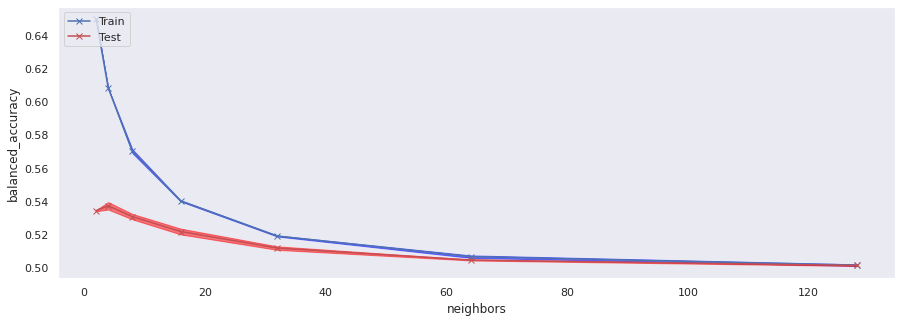

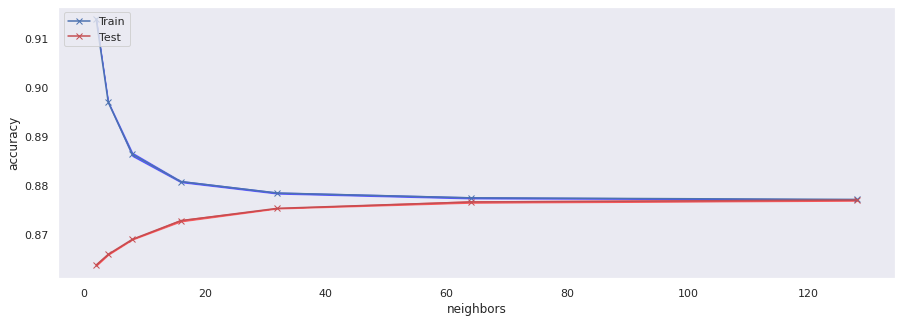

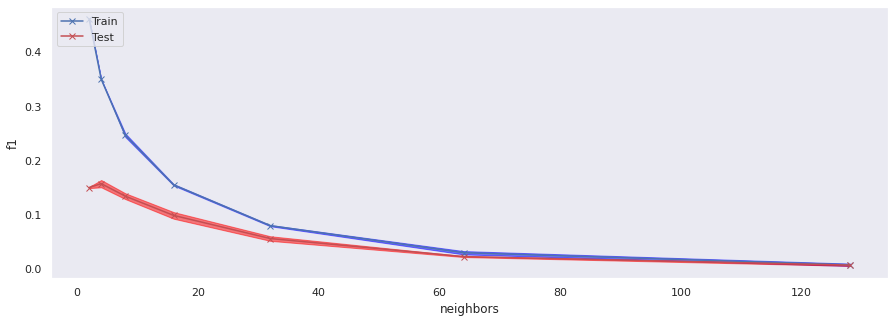

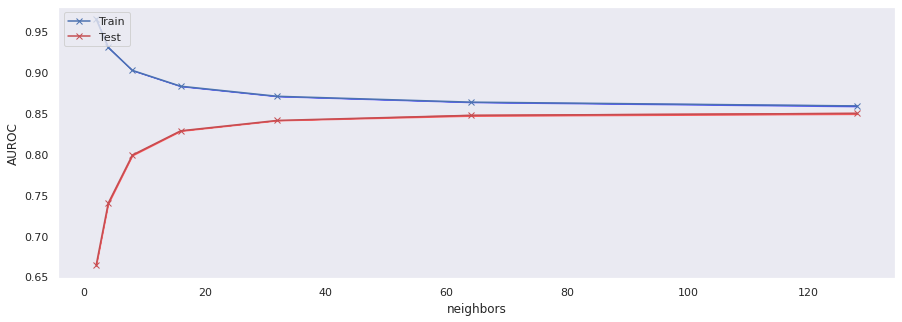

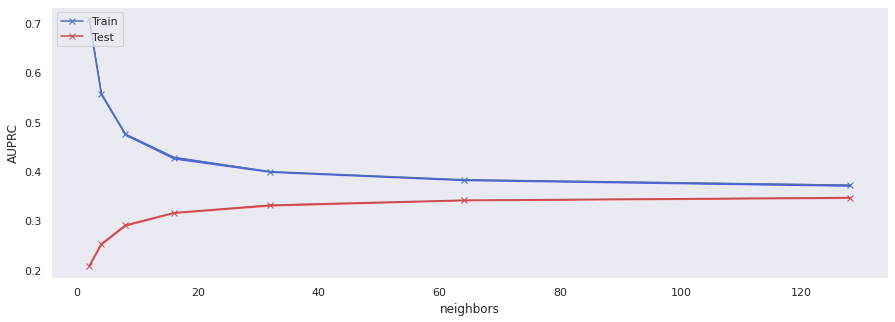

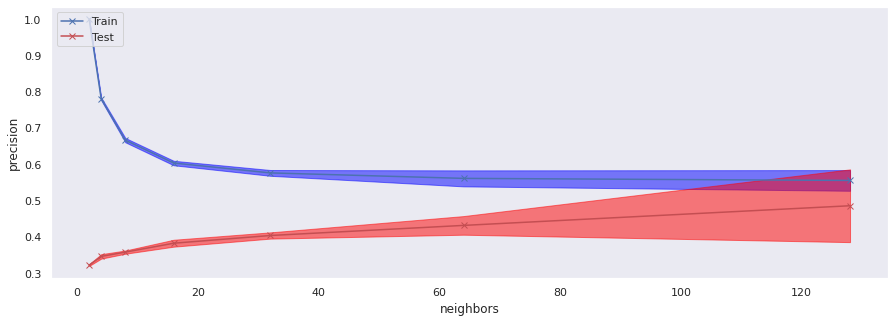

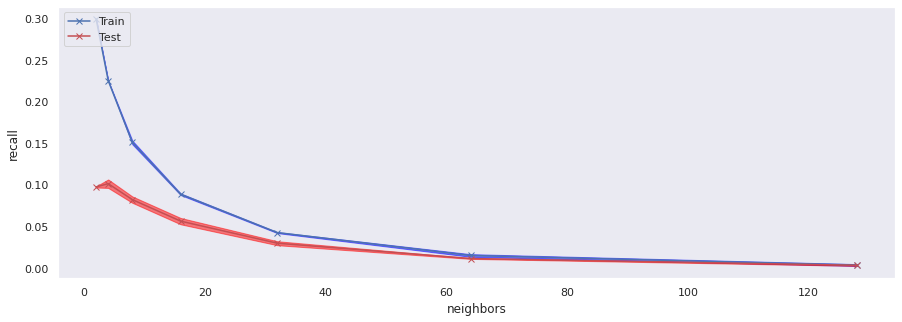

In [ ]:
perf_metric_list = ['balanced_accuracy','accuracy','f1','AUROC','AUPRC','precision','recall']
    
for perf_metric in perf_metric_list :
    plt.figure(figsize=(15,5))


    line1 = plt.plot(dfgrid['param_n_neighbors'] , dfgrid['mean_train_' + perf_metric ] , 'b', label='Train' , marker = 'x')
    fill1 = plt.fill_between( dfgrid['param_n_neighbors'].to_list() , 
                              dfgrid['mean_train_' + perf_metric ] + dfgrid['std_train_' + perf_metric ] ,
                              dfgrid['mean_train_' + perf_metric ] - dfgrid['std_train_' + perf_metric ] , 
                             alpha = 0.5 , color = 'blue' )



    line2 = plt.plot(dfgrid['param_n_neighbors'] , dfgrid[ 'mean_test_' + perf_metric ] , 'r', label='Test ' , marker = 'x')
    fill2 = plt.fill_between( dfgrid['param_n_neighbors'].to_list() , 
                              dfgrid['mean_test_' + perf_metric ] + dfgrid['std_test_' + perf_metric ] ,
                              dfgrid['mean_test_' + perf_metric ] - dfgrid['std_test_' + perf_metric ] , 
                             alpha = 0.5 , color = 'red' )



    plt.grid(color='b', ls = '-.', lw = 0.5 )
    plt.legend( loc = 'upper left' )
    plt.ylabel( perf_metric )
    plt.xlabel( 'neighbors' )
    plt.show()

In [ ]:
ESC

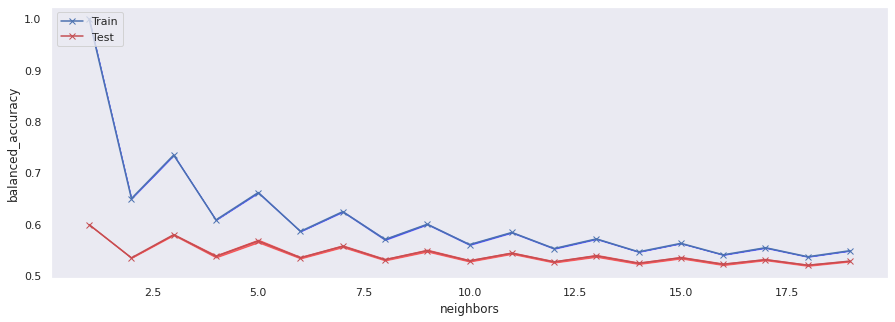

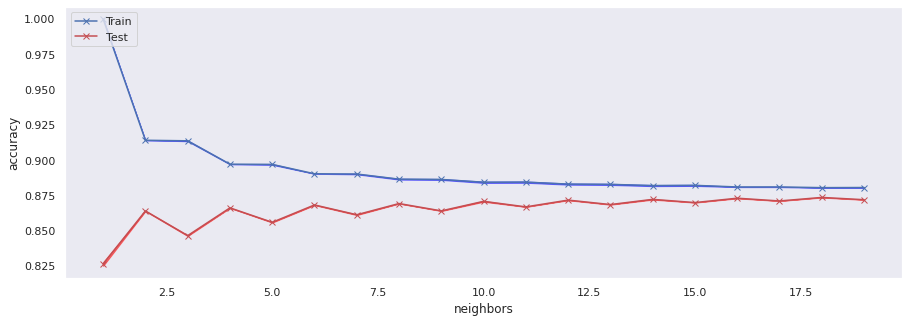

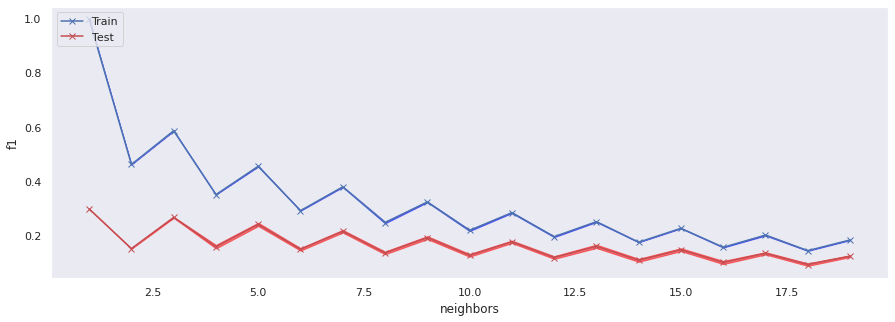

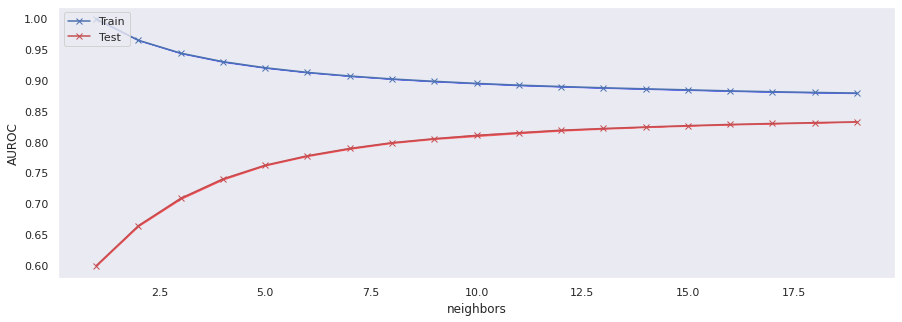

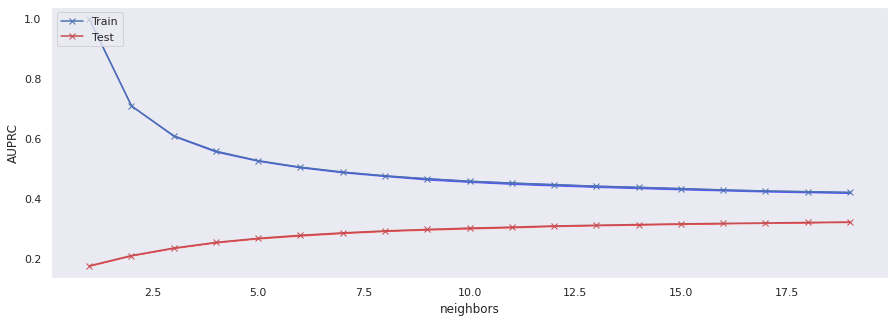

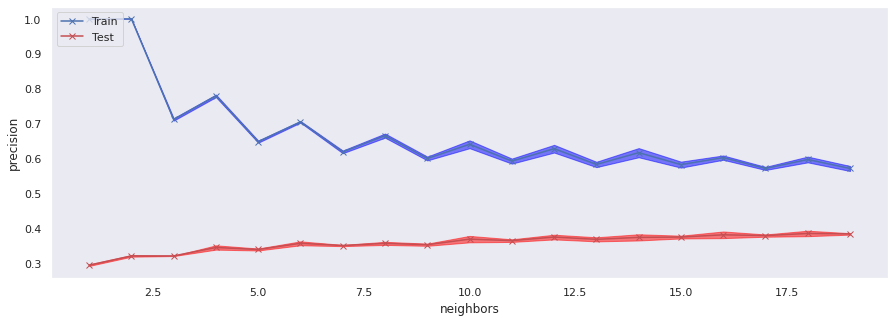

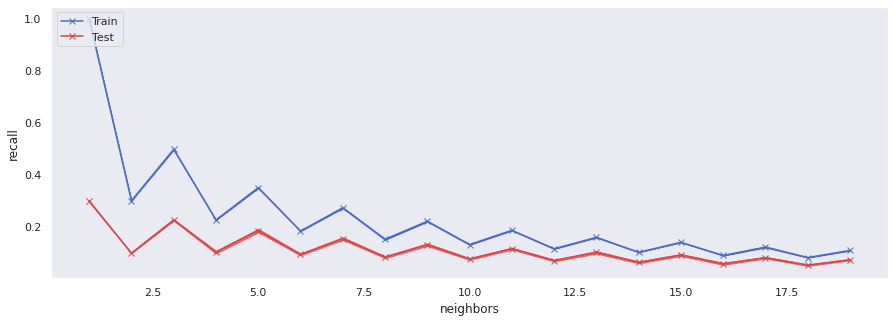

In [ ]:
perf_metric_list = ['balanced_accuracy','accuracy','f1','AUROC','AUPRC','precision','recall']
    
for perf_metric in perf_metric_list :
    plt.figure(figsize=(15,5))


    line1 = plt.plot(dfgrid['param_n_neighbors'] , dfgrid['mean_train_' + perf_metric ] , 'b', label='Train' , marker = 'x')
    fill1 = plt.fill_between( dfgrid['param_n_neighbors'].to_list() , 
                              dfgrid['mean_train_' + perf_metric ] + dfgrid['std_train_' + perf_metric ] ,
                              dfgrid['mean_train_' + perf_metric ] - dfgrid['std_train_' + perf_metric ] , 
                             alpha = 0.5 , color = 'blue' )



    line2 = plt.plot(dfgrid['param_n_neighbors'] , dfgrid[ 'mean_test_' + perf_metric ] , 'r', label='Test ' , marker = 'x')
    fill2 = plt.fill_between( dfgrid['param_n_neighbors'].to_list() , 
                              dfgrid['mean_test_' + perf_metric ] + dfgrid['std_test_' + perf_metric ] ,
                              dfgrid['mean_test_' + perf_metric ] - dfgrid['std_test_' + perf_metric ] , 
                             alpha = 0.5 , color = 'red' )



    plt.grid(color='b', ls = '-.', lw = 0.5 )
    plt.legend( loc = 'upper left' )
    plt.ylabel( perf_metric )
    plt.xlabel( 'neighbors' )
    plt.show()

In [ ]:
ESC

### Final KNN Training run

In [ ]:
# Refer Documentation od KNN Defalut Patrameters and notes above

knn = get_model(n=3)

knn.fit(X = X_train , y = Y_train )

#knn.predict()
#knn.predict_proba()


Pipeline(steps=[('RobustScaler', RobustScaler()),
                ('KNN',
                 KNeighborsClassifier(algorithm='kd_tree', leaf_size=300,
                                      metric='manhattan', n_jobs=-1,
                                      n_neighbors=3))])

In [ ]:
Y_train_pred=knn.predict(X_train)
Y_test_pred =knn.predict(X_test )

Y_train_pred=pd.DataFrame(Y_train_pred);
Y_test_pred =pd.DataFrame(Y_test_pred );


Confusion matrix Format
[ [ tn , fp ]     all 0z
  [ fn , tp ] ]   all 1z
    

Confusion Matrix for Train :

[[292422   8520]
 [ 21137  20919]]

[[0.85254725 0.02483979]
 [0.06162427 0.06098869]]


Confusion Matrix for Test :

[[31176  2281]
 [ 3579  1075]]

[[0.81803154 0.05985149]
 [0.09390989 0.02820708]]



###########################################################################

F1 Score for Train :  0.5851877753689069
F1 Score for Test  :  0.26841448189762795
F1 Score for Train Dummy :  0.12253058504308087
F1 Score for Test  Dummy :  0.12093223069487702


Training Classification Report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95    313559
           1       0.50      0.71      0.59     29439

    accuracy                           0.91    342998
   macro avg       0.73      0.82      0.77    342998
weighted avg       0.93      0.91      0.92    342998


Testing  Classification Report
              precision    recall  f1

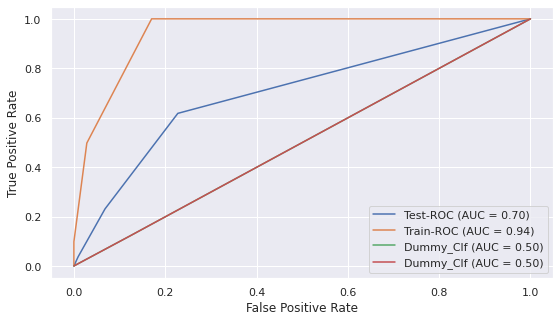

In [ ]:
get_classifier_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , knn )


# Random Forrests of Decsision Trees

------------
### Default Parameters : RandomForestClassifier 

see collapsed code below

In [ ]:
RandomForestClassifier(
                       n_estimators=100, 
                       # The number of trees in the forest.
                       
                       criterion='gini', 
                       # The function to measure the quality of a split. 
                       # Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
                       
                       #why entropy ? 
                                  #entropy is more curvy giving a higher amplification at the lower end , 
                                  #and more plateauness at the mid end  , thus making presumably better predictions
                                  
                       # GINI is infact easier to compute thus giving a small boost in spped , 
                                  # the difference is not much , but it will be better to go with Gini for that extra little speed boost
                                 
                       #So should you use Gini impurity or entropy? The truth is, most of the time it does not make a big
                                  #difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default.
                                  #However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the
                                  #tree, while entropy tends to produce slightly more balanced trees.
                                  
                                  
                       
                       max_depth=None, 
                       # he maximum depth of the tree. 
                       # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
                       
                       
                       min_samples_split=2, 
                       #The minimum number of samples required to split an internal node:
                         #If int, then consider min_samples_split as the minimum number.
                         #If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
                       
                       
                       min_samples_leaf=1, 
                       # The minimum number of samples required to be at a leaf node. 
                       # A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
                       # This may have the effect of smoothing the model, especially in regression.
                         # If int, then consider min_samples_leaf as the minimum number.
                         # If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
                       
                       
                       min_weight_fraction_leaf=0.0, 
                       # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
                       # Samples have equal weight when sample_weight is not provided.
                       
                       
                       max_features='auto', 
                       # The number of features to consider when looking for the best split:
                         #If int, then consider max_features features at each split.
                         #If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
                         #If “auto”, then max_features=sqrt(n_features).
                         #If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
                         #If “log2”, then max_features=log2(n_features).
                         #If None, then max_features=n_features.
                       #Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
                       
                       
                       max_leaf_nodes=None, 
                       # Grow trees with max_leaf_nodes in best-first fashion. 
                       # Best nodes are defined as relative reduction in impurity. 
                       #  If None then unlimited number of leaf nodes.
                       
                       
                       min_impurity_decrease=0.0, 
                       # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                       # The weighted impurity decrease equation is complicated , dont use this shit:
    
                       
                       min_impurity_split=None, 
                       # Threshold for early stopping in tree growth. 
                       # A node will split if its impurity is above the threshold, otherwise it is a leaf.
                       
                       bootstrap=True, 
                       # Whether bootstrap samples are used when building trees. 
                       # If False, the whole dataset is used to build each tree.
                       
                       oob_score=False, 
                       # Whether to use out-of-bag samples to estimate the generalization accuracy.
                       
                       n_jobs=None, 
                       # The number of jobs to run in parallel. 
                       
                       random_state=None, 
                       # Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) 
                       #   and the sampling of the features to consider when looking for the best split at each node 
    
                       verbose=0, 
                       # Controls the verbosity when fitting and predicting.
                       
                       warm_start=False, 
                       # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, 
                       #  otherwise, just fit a whole new forest.
                       
                       class_weight=None, 
                       # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. 
                       
                       #  The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
                       #  The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

    
                       ccp_alpha=0.0, 
                       # Complexity parameter used for Minimal Cost-Complexity Pruning. 
                        #  The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. 
                        #  By default, no pruning is performed.
                       
    
                       max_samples=None 
                       #The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), 
                       # otherwise the whole dataset is used to build each tree.
    
                       # If bootstrap is True, the number of samples to draw from X to train each base estimator.
                       # If None (default), then draw X.shape[0] samples.
                       # If int, then draw max_samples samples.
                       # If float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0, 1).
                      ) 

---
### Base Estimator Generator Function
Finalized Params Store : Change the default global parameters here

In [ ]:
def get_RFDT():
    return RandomForestClassifier(n_estimators=100, 
                                   
                                  max_depth=20 , 
                                  min_samples_leaf = 7 , 

                                  max_features=0.75 , 
                                   # The number of features to consider when looking for the best split:
                                     #If int, then consider max_features features at each split.
                                     #If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
                                     #If “auto”, then max_features=sqrt(n_features).
                                     #If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
                                     #If “log2”, then max_features=log2(n_features).
                                     #If None, then max_features=n_features.
                                   #Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.


                                  max_samples=0.1 ,
                                   #The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), 
                                   # otherwise the whole dataset is used to build each tree.

                                   # If bootstrap is True, the number of samples to draw from X to train each base estimator.
                                   # If None (default), then draw X.shape[0] samples.
                                   # If int, then draw max_samples samples.
                                   # If float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0, 1).


                                  ccp_alpha = 1e-4,    #0.7e-6, 
                                   # Complexity parameter used for Minimal Cost-Complexity Pruning. 
                                    #  The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. 
                                    #  By default, no pruning is performed.

                                  
                                  class_weight='balanced',# {class_label: weight}
                                  # {0: 1, 1: 5}
                                  #very important
                                  # see docs about this

                                  
                                  max_leaf_nodes=None, 
                                   # Grow trees with max_leaf_nodes in best-first fashion. 
                                   # Best nodes are defined as relative reduction in impurity. 
                                   #  If None then unlimited number of leaf nodes.

                                   # Whether bootstrap samples are used when building trees. 
                                   # If False, the whole dataset is used to build each tree.
                                  
                                  
                                  oob_score=False,                        
                                  bootstrap=True, 

                                  criterion='gini',
                                  n_jobs=-1,
                                  random_state=42, 
                                  verbose=0,#42000, 
                                  warm_start=False,
                                 ) 

---
### HyperParameter tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

Params_GridSearch_RFDT = {
    'max_depth':list(range(5,25)),
    #'min_samples_leaf':list(range(4,10)),                         
}

#CV_GridSearch_RFDT  = ShuffleSplit ( test_size = 0.25 , train_size = 0.75 , n_splits = 4 )
CV_GridSearch_RFDT  = RepeatedStratifiedKFold ( n_splits = 4 , n_repeats = 1 )

GridExplore = GridSearchCV(estimator = get_RFDT() , 
                                     
                                     param_grid=Params_GridSearch_RFDT,
                           
                                     cv=CV_GridSearch_RFDT, 
                                     scoring=scoring_GS_RFDT_Extended ,
                                                                          
                                     verbose=200 ,
                                     n_jobs=1 , 
                                     pre_dispatch='2*n_jobs' , 
                                     # try setting this to 1 , incase memory explosion still takes place after only 1 job in GridSearchCV , Read DocStrings
                                     
                                     error_score=np.nan,
                                     return_train_score=True,
                                     refit=False
                                    )


GridExplore.fit(X=X_train, y=Y_train)



Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=5 .....................................................
[CV]  max_depth=5, AUPRC=(train=0.346, test=0.345), AUROC=(train=0.851, test=0.851), RF_Complexity=(train=0.000, test=0.000), RF_Depth=(train=5.000, test=5.000), RF_Leaf_Count=(train=20.980, test=20.980), RF_Vert_Density=(train=4.196, test=4.196), accuracy=(train=0.694, test=0.698), balanced_accuracy=(train=0.797, test=0.799), f1=(train=0.428, test=0.431), precision=(train=0.278, test=0.280), recall=(train=0.933, test=0.932), total=   3.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[CV] max_depth=5 .....................................................
[CV]  max_depth=5, AUPRC=(train=0.350, test=0.343), AUROC=(train=0.852, test=0.849), RF_Complexity=(train=0.000, test=0.000), RF_Depth=(train=5.000, test=5.000), RF_Leaf_Count=(train=20.790, t

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=4, random_state=None),
             estimator=RandomForestClassifier(ccp_alpha=0.0001,
                                              class_weight='balanced',
                                              max_depth=20, max_features=0.75,
                                              max_samples=0.1,
                                              min_samples_leaf=7, n_jobs=-1,
                                              random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24]},
             refit=Fals...
                      'RF_Complexity': <function RF_Forrest_Memorization_Complexity at 0x7fce97904790>,
                      'RF_Depth': <function RF_Forrest_Depth at 0x7fce97904d30>,
                      'RF_Leaf_Count': <function RF_Forrest_Leaves at 0x7fce97904ca0>,
                    

In [ ]:
dfgrid = pd.DataFrame(GridExplore.cv_results_)
dfgrid.columns.values

array(['mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_max_depth', 'params',
       'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy',
       'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy',
       'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
       'rank_test_balanced_accuracy', 'split0_train_balanced_accuracy',
       'split1_train_balanced_accuracy', 'split2_train_balanced_accuracy',
       'split3_train_balanced_accuracy', 'mean_train_balanced_accuracy',
       'std_train_balanced_accuracy', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy',
       'std_train_accuracy', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split

In [ ]:
#print("best params: %s" % str(GridExplore.best_params_))

In [ ]:
#dfgrid.columns.values

col_list = list(m for m in dfgrid.columns.values if not m.startswith("split") )#and m.endswith("_"))
col_list = list(m for m in col_list if not m.startswith("rank") )#and m.endswith("_"))
col_list = list(m for m in col_list if not m.startswith("std") )#and m.endswith("_"))
col_list = list(m for m in col_list if not m == 'params' )#and m.endswith("_"))
col_list

['mean_fit_time',
 'mean_score_time',
 'param_max_depth',
 'mean_test_balanced_accuracy',
 'mean_train_balanced_accuracy',
 'mean_test_accuracy',
 'mean_train_accuracy',
 'mean_test_f1',
 'mean_train_f1',
 'mean_test_AUROC',
 'mean_train_AUROC',
 'mean_test_AUPRC',
 'mean_train_AUPRC',
 'mean_test_precision',
 'mean_train_precision',
 'mean_test_recall',
 'mean_train_recall',
 'mean_test_RF_Depth',
 'mean_train_RF_Depth',
 'mean_test_RF_Leaf_Count',
 'mean_train_RF_Leaf_Count',
 'mean_test_RF_Vert_Density',
 'mean_train_RF_Vert_Density',
 'mean_test_RF_Complexity',
 'mean_train_RF_Complexity']

In [ ]:
dfgrid = dfgrid[col_list]

In [ ]:
dfgrid[col_list].to_csv( 'GridSearchResults_RFDT_Test4.csv')


In [ ]:
perf_metric_list = list(scoring_GS_RFDT_Extended.keys())

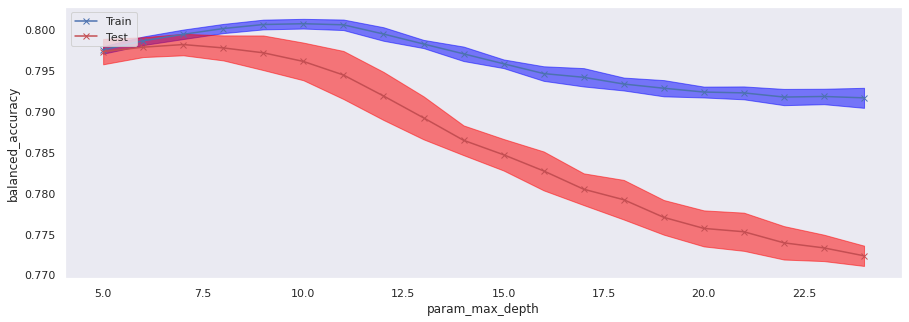

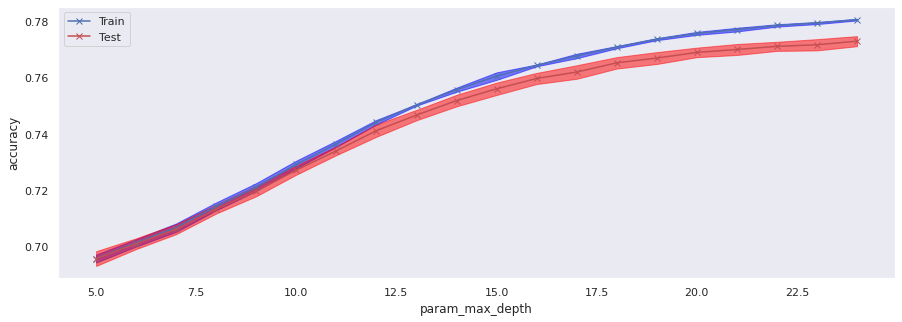

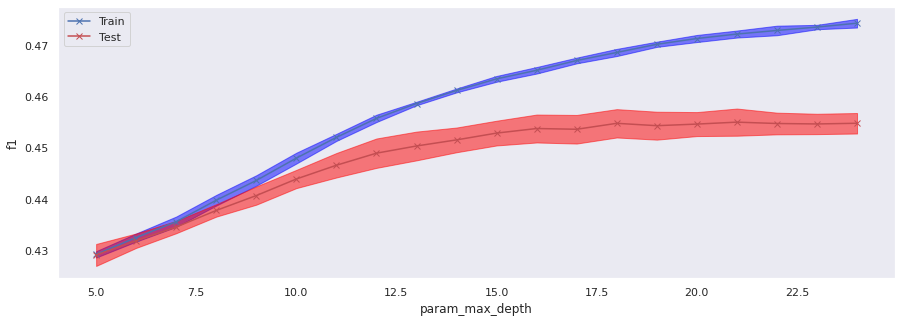

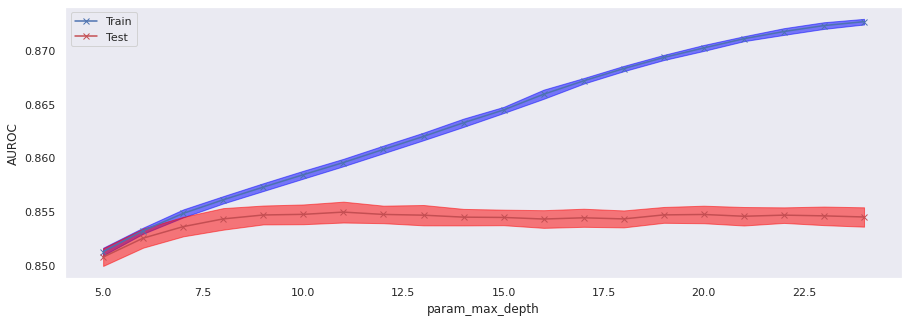

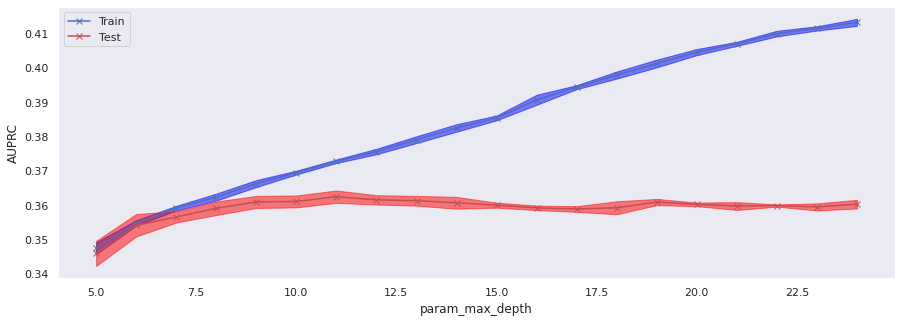

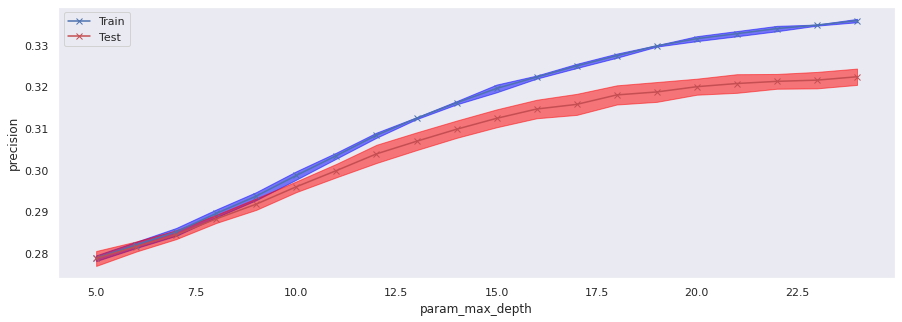

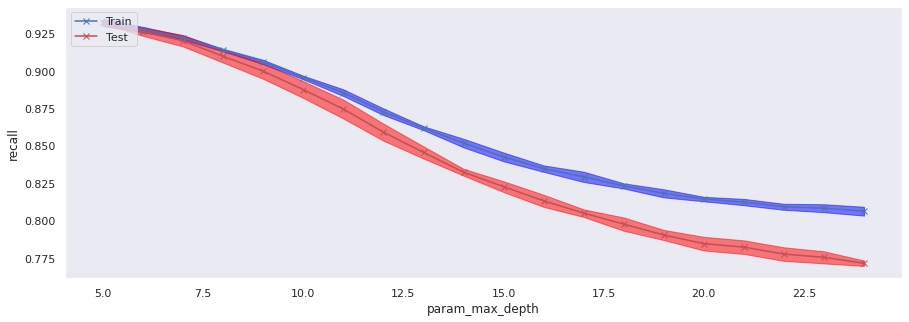

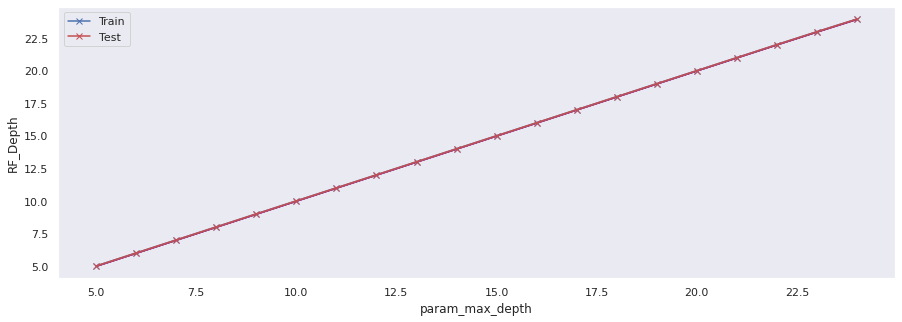

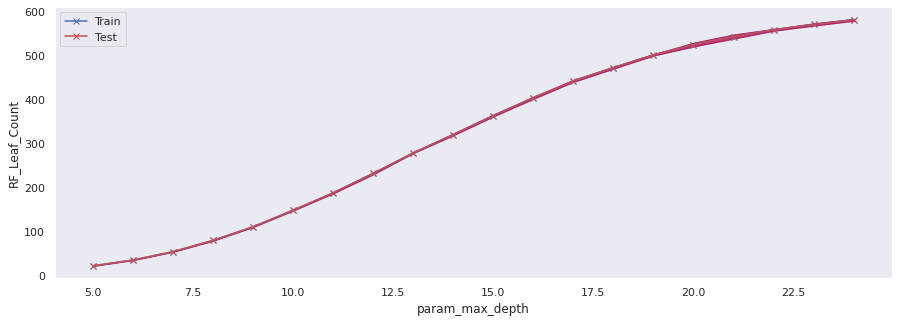

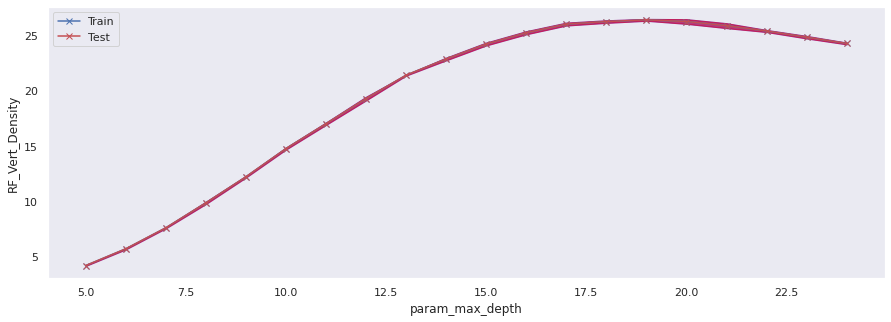

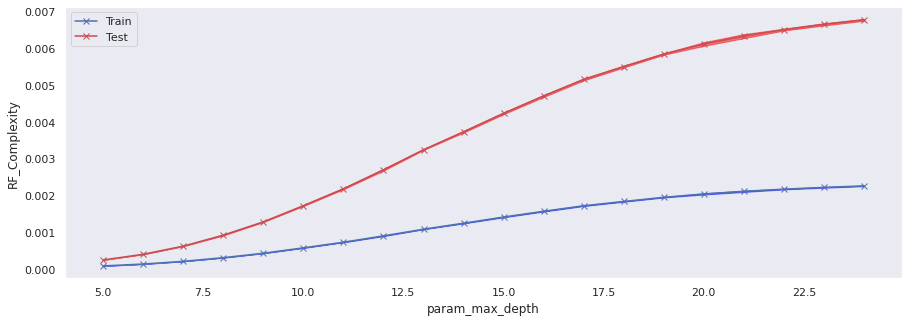

In [ ]:
# Code for plotting curves of train vs test , 
# but ony yseful when you are varying one parameter at a time

parameter = 'param_max_depth'


for perf_metric in perf_metric_list :
    plt.figure(figsize=(15,5))


    line1 = plt.plot(dfgrid[parameter] , dfgrid['mean_train_' + perf_metric ] , 'b', label='Train' , marker = 'x')
    fill1 = plt.fill_between( dfgrid[parameter].to_list() , 
                              dfgrid['mean_train_' + perf_metric ] + dfgrid['std_train_' + perf_metric ] ,
                              dfgrid['mean_train_' + perf_metric ] - dfgrid['std_train_' + perf_metric ] , 
                             alpha = 0.5 , color = 'blue' )



    line2 = plt.plot(dfgrid[parameter] , dfgrid[ 'mean_test_' + perf_metric ] , 'r', label='Test ' , marker = 'x')
    fill2 = plt.fill_between( dfgrid[parameter].to_list() , 
                              dfgrid['mean_test_' + perf_metric ] + dfgrid['std_test_' + perf_metric ] ,
                              dfgrid['mean_test_' + perf_metric ] - dfgrid['std_test_' + perf_metric ] , 
                             alpha = 0.5 , color = 'red' )



    plt.grid(color='b', ls = '-.', lw = 0.5 )
    plt.legend( loc = 'upper left' )
    plt.ylabel( perf_metric )
    plt.xlabel( parameter )
    plt.show()

---

### Final Training Run


In [ ]:
tree_clf = get_RFDT()

tree_clf.fit(X_train , Y_train)

RandomForestClassifier(ccp_alpha=0.0001, class_weight='balanced', max_depth=20,
                       max_features=0.75, max_samples=0.1, min_samples_leaf=7,
                       n_jobs=-1, random_state=42)

In [ ]:
depth_list = np.array([])
leaves_list = np.array([])

for i in range(len(tree_clf.estimators_)):
    depth_list  = np.append( depth_list , tree_clf.estimators_[i].get_depth()   )
    leaves_list = np.append(leaves_list , tree_clf.estimators_[i].get_n_leaves())

print('Forrest Depth             :',        int( depth_list.mean()) , ' +- ' , depth_list.std())
print('Forrest Leaves count      :',        int(leaves_list.mean()) , ' +- ' , int(leaves_list.std()))
print('Forrest Vertical Leaves Density   :',int(leaves_list.mean()/depth_list.mean()))
print('Forrest Memorization Complexity   :',int(leaves_list.mean())/X_train.shape[0])



#print('Max theoretically possible Leaves count for this depth : ')
#print('                 ' , 2**int(depth_list.mean()) )
#print('Forrest ',depth_list)
#print('Forrest ',leaves_list)

Forrest Depth             : 20  +-  0.0
Forrest Leaves count      : 468  +-  25
Forrest Vertical Leaves Density   : 23
Forrest Memorization Complexity   : 0.0013644394427955848


In [ ]:
Y_train_pred=tree_clf.predict(X_train)
Y_test_pred =tree_clf.predict(X_test )

Y_train_pred=pd.DataFrame(Y_train_pred);
Y_test_pred =pd.DataFrame(Y_test_pred );



Confusion matrix Format
[ [ tn , fp ]     all 0z
  [ fn , tp ] ]   all 1z
    

Confusion Matrix for Train :

[[226082  74860]
 [  6487  35569]]

[[0.65913504 0.218252  ]
 [0.01891265 0.10370031]]


Confusion Matrix for Test :

[[24891  8566]
 [  876  3778]]

[[0.65311852 0.2247645 ]
 [0.02298549 0.09913148]]



###########################################################################

F1 Score for Train :  0.4665245761878217
F1 Score for Test  :  0.4445228850452995
F1 Score for Train Dummy :  0.12253058504308087
F1 Score for Test  Dummy :  0.12093223069487702


Training Classification Report
              precision    recall  f1-score   support

           0       0.75      0.97      0.85    232569
           1       0.85      0.32      0.47    110429

    accuracy                           0.76    342998
   macro avg       0.80      0.65      0.66    342998
weighted avg       0.78      0.76      0.72    342998


Testing  Classification Report
              precision    recall  f1-

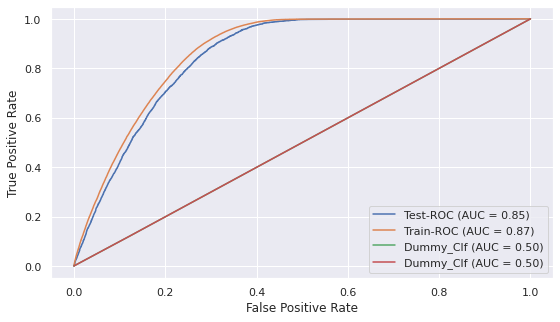

In [ ]:
get_classifier_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , tree_clf )

# Gradient Boosted Trees using XGBoost Library

------

### XGBoost algorithn training and tuning notes


----

A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.


----

 Bias Variance Tradeoff in depth and number of trees

GPU multiple shallow trees [ default ] 
gpuMaxDepth = 6; 
gpuNTrees = 10; 

GPU few/one deep trees [ experiment with this setting for faster training with comparable accuracy ]
gpuMaxDepth = 15; 
gpuNTrees = 1

paramsGPU = {
    'max_depth': gpuMaxDepth,
    'n_estimators': gpuNTrees,    
}


----

Handle Imbalanced Dataset
If you care only about the overall performance metric (AUC) of your prediction.
    Balance the positive and negative weights via scale_pos_weight.
    Use AUC for evaluation.

If you care about predicting the right probability.
    In such a case, you cannot re-balance the dataset.
    Set parameter max_delta_step to a finite number (say 1) to help convergence.


----

scale_pos_weight hyperparameter

By default, the scale_pos_weight hyperparameter is set to the value of 1.0 and has the effect of weighing the balance of positive examples, relative to negative examples when boosting decision trees. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1)

The scale_pos_weight value is used to scale the gradient for the positive class.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

scale_pos_weight = total_negative_examples / total_positive_examples

In practice, that works pretty well, but if your dataset is extremely unbalanced I'd recommend using something more conservative like:
scale_pos_weight = sqrt(count(negative examples)/count(Positive examples)) 


so for a 80/20 split of threshold crosses vs wait instances : we can say that 4 should be a good value 
but we dont need to go all the way and create the exact opposite compensation to create a equal balance 

if reality is unbalanced , so should be our data to some extent retain that quality 
a value of 2 would seem optimal as of now 


----

Strategy 

Control Overfitting
When you observe high training accuracy, but low test accuracy, it is likely that you encountered overfitting problem.

There are in general two ways that you can control overfitting in XGBoost:

The first way is to directly control model complexity.
    This includes max_depth, min_child_weight and gamma.

The second way is to add randomness to make training robust to noise.
    This includes subsample and colsample_bytree.
    You can also reduce stepsize eta. Remember to increase num_round when you do so.
    

----
 
Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

As you can see that here we got 140 as the optimal estimators for 0.1 learning rate. Note that this value might be too high for you depending on the power of your system. In that case you can increase the learning rate and re-run the command to get the reduced number of estimators.

----

max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.

min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.

gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.

subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.

----

Tune tree-specific parameters ( first : max_depth, min_child_weight, ;
then : gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

Lower the learning rate and decide the optimal parameters .

----

Early stopping

The number of boosted trees (`n_estimators`) to train is uncapped, rather training continues until validation has not improved in *n* rounds

`xgb_model.fit()` will produce a model from the last iteration, not the best one, so to get the optimum model consider retraining over `xgb_model.best_iteration` rounds.

---
### XGBoost Estimator Instance Generator Function
#### Finalized Params Store : Change the default global parameters here

In [ ]:
def get_base_XGBC():
    inst = XGBClassifier(
        
        max_bin = 80 , # increase for more complexity , at the cost of training time 
        n_estimators = 50 , # default is 100 , use more 500
        # Learning rate * no.of estimators has been found out to be near 1.8-2.8 for optimal F1 score performance
        
        max_depth    = 5 , #7 , # default = 6 #4-16-40
        learning_rate  =  0.15 , # default = 0.3  # 0.01-0.2 is usually convergence
        max_delta_step = 20 , # 0-10 , read notes above
        
        min_child_weight = 25, # default = 1 , range 0- inf
        scale_pos_weight = 5 , # read detiled note and docs both
        
        subsample = 0.7 , # usual range 0.5-1 try out all 5 : 0.6,0.7,,
        colsample_bytree = 0.7 , # Typical values: 0.5-1 
        
        gamma      = 1e-4 , # usually 0-0.5 use GS        
        reg_alpha  = 20 , #  l1 Norm [1e-5, 1e-2, 0.1, 1, 100]
        reg_lambda = 0.005 , # L2 Norm [1e-5, 1e-2, 0.1, 1, 100] GS

       
        objective='binary:logistic',
        booster='gbtree', # try DART , no GPU but its unique
        tree_method='hist',#'gpu_hist',# 'gpu_exact' is deprecated , # auto, exact, approx, hist, gpu_hist
        #updater = 'grow_gpu_hist',
        #gpu_id=0, 
        
        validate_parameters=True, 
        importance_type='gain', 
        num_parallel_tree=1, # try 16 later # Used for boosting random forest.
        n_jobs=-1, 
        verbosity=3,
        random_state=42,
        use_label_encoder=False
        
        #eval_set=[ (X_train , Y_train) , (X_test , Y_test) ], 
        #eval_metric = ["auc" , "logloss"], # read docs above for definition of custom metrics , and more 
        #early_stopping_rounds=20
              )
    return inst

In [ ]:
get_fit_params={"early_stopping_rounds":30, 
            "eval_metric" : ['f1' , 'auc'], 
            "eval_set" : [ [X_train , Y_train] , [X_test , Y_test] ] ,
            "verbose" : 3
           }

-------
### HyperParameter tuning using BayesSearchCV

In [ ]:
# callback handler
import copy
global counter 
global same_result_counter
global prev_best

counter = 0
same_result_counter = 0
prev_best = 0



def on_step(optim_result):
    global counter
    global same_result_counter
    global prev_best
    
    score = float( BayesExplore.best_score_ )
    params =  str( BayesExplore.best_params_)
        
        
    if str(prev_best) == str(score) :
        same_result_counter +=1
    else :
        same_result_counter = 0
        
        
    print()
    print("Iteration count   : %s" % counter)
    print("Same Result count : %s" % same_result_counter)
    print("best score        : %s" % score)
    print("best params       : %s" % params)
    print()
    counter +=1
    
    prev_best = copy.deepcopy(score)
    
    if score >= 0.65 :
        print('Interrupting! 0.55 f1 Achieved ')
        return True


In [ ]:
from sklearn.model_selection import ShuffleSplit
from skopt.utils import Integer, Real

#np.geomspace(1,1000,num=10,dtype=int) 
#[0.001 , 0.005 , 0.01 , 0.05 , 0.1 , 0.5 , 1 , 5 , 10 , 50 , 100 ]#, 1000]

Params_BayesSearch_XGB_Continous = {
#    'n_estimators': Integer(50 , 350 , 'uniform' ),
    'learning_rate':   Real( 0.001 , 0.25 , 'uniform'),
    'max_depth':    Integer( 5 , 30 , 'uniform' ),
#    'max_delta_step':  Real(0, 50, 'uniform'),
#    'max_bin':      Integer(10,250, 'uniform' ),

#    'subsample': Real(0.65, 1.0, 'uniform'),
#    'colsample_bytree': Real(0.65, 1.0, 'uniform'),

    'scale_pos_weight': Real(1 , 5 , 'uniform'),
    'min_child_weight': Real(0 , 15  , 'uniform'),
    
    #'gamma':      Real(1e-3, 0.5, 'log-uniform'),
    #'reg_lambda': Real(1e-4, 1  , 'log-uniform'),
    #'reg_alpha':  Real(1e-4, 1  , 'log-uniform'),
    }

In [ ]:
CV_BayesSearch = ShuffleSplit( test_size = 0.005 , train_size = 0.005 , n_splits = 3 )
#CV_BayesSearch = RepeatedStratifiedKFold( n_splits = 3 , n_repeats = 1 , random_state = 42 )

Bayes_xgb_inst = get_base_XGBC()
#Bayes_xgb_inst.verbosity  = 0

BayesExplore = BayesSearchCV(
    estimator = get_base_XGBC() , # Bayes_xgb_inst  , 
                    search_spaces = Params_BayesSearch_XGB_Continous , 
                    cv=CV_BayesSearch,                     
                    scoring=scoring_BS, 
                    #fit_params = get_fit_params , 
                    
                    n_iter=10, 
                    # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution. 
                    # Consider increasing n_points if you want to try more parameter settings in parallel.
                    
                    n_jobs=-1,#-1, 
                    # Number of jobs to run in parallel. 
                    # At maximum there are n_points times cv jobs available during each iteration.
                    
                    #  SO IF THERE ARE 4 CV FOLDS , THEN ONLY 4 CORES WILL BE USED UNLESS n_points is also set to 4 
                    #    then 4x4 16 fold will be properly used 
                    # hence n_points is also important to be set 
                    # be careful of RAM explosion though 
                    
                                                          
                    n_points=1, # only for CPU
                    # Number of parameter settings to sample in parallel. 
                    
                    pre_dispatch='1*n_jobs', # only for CPU
                    # Controls the number of jobs that get dispatched during parallel execution. 
                    # Reducing this number can be useful to avoid an explosion of memory consumption 
                    #  when more jobs get dispatched than CPUs can process. This parameter can be:

                    # None, in which case all the jobs are immediately created and spawned. 
                    #     Use this for lightweight and fast-running jobs, to avoid delays due to on-demand spawning of the jobs
                    # An int, giving the exact number of total jobs that are spawned
                    # A string, giving an expression as a function of n_jobs, as in ‘2*n_jobs’                    

                     
                    iid=True, 
                    refit=False,
                    error_score=np.nan,#'raise', 
                    return_train_score=True ,
                    random_state=42, 
                    verbose=4200, 
                          )


BayesExplore.fit(X=X_train, y=Y_train , callback=on_step )

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s finished

Iteration count   : 0
Same Result count : 0
best score        : 0.17935797965540368
best params       : OrderedDict([('learning_rate', 0.10311588575447515), ('max_depth', 23), ('min_child_weight', 13.993019982717508), ('scale_pos_weight', 2.263198373948195)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.9s remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
print("val. score: %s" % BayesExplore.best_score_)
#print("test score: %s" % BayesExplore.score(X_test, Y_test))
print('best params:')
print(BayesExplore.best_params_)

In [ ]:
dfgrid = pd.DataFrame(BayesExplore.cv_results_)
dfgrid = dfgrid.dropna()

In [ ]:
dfgrid.columns.values

In [ ]:

col_list = list(m for m in dfgrid.columns.values if not m.startswith("split") )#and m.endswith("_"))
col_list = list(m for m in col_list if not m.startswith("std") )#and m.endswith("_"))
col_list

In [ ]:

dfgrid[col_list].to_csv('BayesSearchResults_XGBST_Test1.csv')
#dfgrid.to_csv('GridSearchResults_XGBST_1.csv')

In [ ]:
#  BAYES  EXPLORE VERSION

# Code for plotting curves of train vs test , 
# but ony yseful when you are varying one parameter at a time


parameter = 'param_min_samples_leaf'

from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(dfgrid[parameter] , dfgrid['mean_train_score'] , 'b', label='Train' , marker = 'x')
line2 = plt.plot(dfgrid[parameter] , dfgrid['mean_test_score' ] , 'r', label='Test ' , marker = 'x')


plt.legend(loc = 'upper left')
plt.ylabel('Metric')
plt.xlabel(parameter)
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.show()

### FInal Training Run for XGBoost 


In [ ]:
final_XGBC_clf = get_base_XGBC()

final_XGBC_clf.fit( X_train , Y_train ) #, **get_fit_params )

[02:53:16] INFO: /opt/conda/envs/rapids/conda-bld/xgboost_1607619219243/work/src/gbm/gbtree.cc:176: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[02:53:16] INFO: /opt/conda/envs/rapids/conda-bld/xgboost_1607619219243/work/src/gbm/gbtree.cc:176: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[02:53:16] ======== Monitor: HostSketchContainer ========
[02:53:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1607619219243/work/src/common/timer.cc:99: Timer for AllReduce did not get stopped properly.
[02:53:16] MakeCuts: 0.00088s, 1 calls @ 880us

[02:53:16] PushRowPage: 0.032925s, 1 calls @ 32925us

[02:53:16] INFO: /opt/conda/envs/rapids/conda-bld/xgboost_1607619219243/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[02:53:16] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1607619219243/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the de

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_bin=80, max_delta_step=20, max_depth=5,
              min_child_weight=25, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=20, reg_lambda=0.005, scale_pos_weight=5, subsample=0.7,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=True, verbosity=3)

In [ ]:
Y_train_pred=final_XGBC_clf.predict(X_train)
Y_test_pred =final_XGBC_clf.predict(X_test )

Y_train_pred=pd.DataFrame(Y_train_pred);
Y_test_pred =pd.DataFrame(Y_test_pred );


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

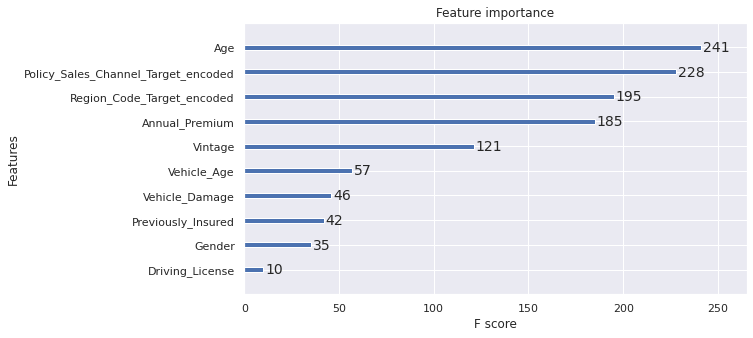

In [ ]:
from xgboost import plot_importance

plot_importance(final_XGBC_clf , max_num_features = 20)


Confusion matrix Format
[ [ tn , fp ]     all 0z
  [ fn , tp ] ]   all 1z
    

Confusion Matrix for Train :

[[215760  85182]
 [  5139  36917]]

[[0.62904157 0.24834547]
 [0.01498259 0.10763037]]


Confusion Matrix for Test :

[[23804  9653]
 [  602  4052]]

[[0.62459657 0.25328645]
 [0.01579596 0.10632101]]



###########################################################################

F1 Score for Train :  0.44978221802564655
F1 Score for Test  :  0.4414183779072934
F1 Score for Train Dummy :  0.12253058504308087
F1 Score for Test  Dummy :  0.12093223069487702


Training Classification Report
              precision    recall  f1-score   support

           0       0.72      0.98      0.83    220899
           1       0.88      0.30      0.45    122099

    accuracy                           0.74    342998
   macro avg       0.80      0.64      0.64    342998
weighted avg       0.77      0.74      0.69    342998


Testing  Classification Report
              precision    recall  f1

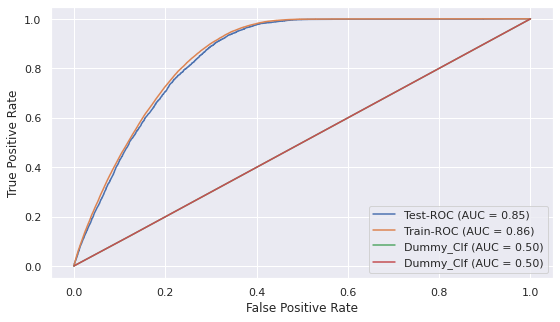

In [ ]:
get_classifier_analytics( Y_train ,  Y_train_pred , Y_test , Y_test_pred , X_train , X_test , final_XGBC_clf )


-------